In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
import xgboost as xg
%matplotlib inline

data = pd.read_csv('data/train.csv')
data.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

data['Embarked'].fillna('S',inplace=True)

In [4]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [5]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

In [6]:
data['Fare_Range']=pd.qcut(data['Fare'],4)

data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

In [7]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [8]:
# data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
data.drop(['Name','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
#sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
#fig=plt.gcf()
#fig.set_size_inches(18,15)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.show()

# 模型部分

In [9]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

test_X.info()
test_X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 421 to 607
Data columns (total 11 columns):
Pclass         268 non-null int64
Sex            268 non-null int64
Age            268 non-null float64
SibSp          268 non-null int64
Parch          268 non-null int64
Embarked       268 non-null int64
Initial        268 non-null int64
Age_band       268 non-null int64
Family_Size    268 non-null int64
Alone          268 non-null int64
Fare_cat       268 non-null int64
dtypes: float64(1), int64(10)
memory usage: 25.1 KB


,Pclass,Sex,Age,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
421,3,0,21.0,0,0,2,0,1,0,1,0
618,2,1,4.0,2,1,0,2,0,3,0,3
116,3,0,70.5,0,0,2,0,4,0,1,0
310,1,1,24.0,0,0,1,2,1,0,1,3
57,3,0,28.5,0,0,1,0,1,0,1,0


In [11]:
#model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
#model.fit(train_X,train_Y.values.ravel())
#prediction1=model.predict(test_X)


#print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

In [12]:
data = pd.read_csv('data/test.csv')
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46
data['Initial'].value_counts()

Mr        241
Miss       79
Mrs        72
Master     21
Other       4
Dona        1
Name: Initial, dtype: int64

In [13]:


data['Embarked'].fillna('S',inplace=True)

data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4


data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

data['Fare_Range']=pd.qcut(data['Fare'],4)

data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null int64
Initial        418 non-null object
Age_band       418 non-null int64
Family_Size    418 non-null int64
Alone          418 non-null int64
Fare_Range     417 non-null category
Fare_cat       418 non-null int64
dtypes: category(1), float64(2), int64(10), object(4)
memory usage: 52.8+ KB


In [14]:
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other','Dona'],[0,1,2,3,4,4],inplace=True)
data.info()
# data_x=data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1)
data_x=data.drop(['Name','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1)

#sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
#fig=plt.gcf()
#fig.set_size_inches(18,15)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.show()
data_x.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null int64
Initial        418 non-null int64
Age_band       418 non-null int64
Family_Size    418 non-null int64
Alone          418 non-null int64
Fare_Range     417 non-null category
Fare_cat       418 non-null int64
dtypes: category(1), float64(2), int64(11), object(3)
memory usage: 52.8+ KB


,Pclass,Sex,Age,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
0,3,0,34.5,0,0,2,0,2,0,1,0
1,3,1,47.0,1,0,0,1,2,1,0,0
2,2,0,62.0,0,0,2,0,3,0,1,1
3,3,0,27.0,0,0,0,0,1,0,1,1
4,3,1,22.0,1,1,0,1,1,2,0,1


In [15]:
#prediction2=model.predict(data_x)
# submission = pd.DataFrame({
#         "PassengerId": data["PassengerId"],
#         "Survived": prediction2
#     })
# submission.to_csv('submission3.csv', index=False)

# DNN keras

In [16]:
from keras import models
from keras import layers
from keras import optimizers

model_dnn = models.Sequential()
model_dnn.add(layers.Dense(10, activation='relu', input_shape=(11,)))
model_dnn.add(layers.Dense(10, activation='relu'))
model_dnn.add(layers.Dense(1, activation='sigmoid'))

model_dnn.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])


history = model_dnn.fit(train_X,train_Y,
                   epochs=2000,
                   batch_size=1024,
                   validation_data=(test_X, test_Y))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 623 samples, validate on 268 samples
Epoch 1/2000
623/623 [==============================] - 1s 2ms/step - loss: 1.9918 - acc: 0.3836 - val_loss: 1.7046 - val_acc: 0.3843
Epoch 2/2000
623/623 [==============================] - 0s 5us/step - loss: 1.6901 - acc: 0.3836 - val_loss: 1.4930 - val_acc: 0.3918
Epoch 3/2000
623/623 [==============================] - 0s 5us/step - loss: 1.4857 - acc: 0.3852 - val_loss: 1.3299 - val_acc: 0.3955
Epoch 4/2000
623/623 [==============================] - 0s 6us/step - loss: 1.3281 - acc: 0.3820 - val_loss: 1.1989 - val_acc: 0.3955
Epoch 5/2000
623/623 [==============================] - 0s 5us/step - loss: 1.2017 - acc: 0.3836 - val_loss: 1.0927 - val_acc: 0.3955
Epoch 6/2000
623/623 [==============================] - 0s 16us/step - loss: 1.0991 - acc: 0.3884 - val_loss: 1.0067 - val_acc: 0.3955
Epoch 7/2000
623/623 [=======

Epoch 58/2000
623/623 [==============================] - 0s 5us/step - loss: 0.6657 - acc: 0.6453 - val_loss: 0.6549 - val_acc: 0.6604
Epoch 59/2000
623/623 [==============================] - 0s 5us/step - loss: 0.6638 - acc: 0.6453 - val_loss: 0.6531 - val_acc: 0.6567
Epoch 60/2000
623/623 [==============================] - 0s 5us/step - loss: 0.6618 - acc: 0.6453 - val_loss: 0.6514 - val_acc: 0.6567
Epoch 61/2000
623/623 [==============================] - 0s 5us/step - loss: 0.6599 - acc: 0.6453 - val_loss: 0.6498 - val_acc: 0.6604
Epoch 62/2000
623/623 [==============================] - 0s 8us/step - loss: 0.6580 - acc: 0.6421 - val_loss: 0.6481 - val_acc: 0.6604
Epoch 63/2000
623/623 [==============================] - 0s 10us/step - loss: 0.6561 - acc: 0.6421 - val_loss: 0.6464 - val_acc: 0.6604
Epoch 64/2000
623/623 [==============================] - 0s 8us/step - loss: 0.6542 - acc: 0.6404 - val_loss: 0.6448 - val_acc: 0.6604
Epoch 65/2000
623/623 [==============================]

Epoch 119/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5725 - acc: 0.7014 - val_loss: 0.5728 - val_acc: 0.7239
Epoch 120/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5710 - acc: 0.7175 - val_loss: 0.5710 - val_acc: 0.7015
Epoch 121/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5694 - acc: 0.7063 - val_loss: 0.5696 - val_acc: 0.7276
Epoch 122/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5675 - acc: 0.7175 - val_loss: 0.5677 - val_acc: 0.7052
Epoch 123/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5659 - acc: 0.7095 - val_loss: 0.5661 - val_acc: 0.7239
Epoch 124/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5639 - acc: 0.7207 - val_loss: 0.5637 - val_acc: 0.7052
Epoch 125/2000
623/623 [==============================] - 0s 10us/step - loss: 0.5619 - acc: 0.7111 - val_loss: 0.5620 - val_acc: 0.7276
Epoch 126/2000
623/623 [=======================

Epoch 180/2000
623/623 [==============================] - 0s 3us/step - loss: 0.5026 - acc: 0.7657 - val_loss: 0.5075 - val_acc: 0.7463
Epoch 181/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5018 - acc: 0.7592 - val_loss: 0.5064 - val_acc: 0.7500
Epoch 182/2000
623/623 [==============================] - 0s 8us/step - loss: 0.5010 - acc: 0.7673 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 183/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5003 - acc: 0.7608 - val_loss: 0.5048 - val_acc: 0.7537
Epoch 184/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4995 - acc: 0.7657 - val_loss: 0.5043 - val_acc: 0.7500
Epoch 185/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4988 - acc: 0.7657 - val_loss: 0.5032 - val_acc: 0.7537
Epoch 186/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4981 - acc: 0.7657 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 187/2000
623/623 [========================

Epoch 241/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4668 - acc: 0.7865 - val_loss: 0.4671 - val_acc: 0.7575
Epoch 242/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4663 - acc: 0.7721 - val_loss: 0.4680 - val_acc: 0.7836
Epoch 243/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4659 - acc: 0.7881 - val_loss: 0.4660 - val_acc: 0.7649
Epoch 244/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4655 - acc: 0.7721 - val_loss: 0.4670 - val_acc: 0.7799
Epoch 245/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4651 - acc: 0.7881 - val_loss: 0.4650 - val_acc: 0.7649
Epoch 246/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4647 - acc: 0.7705 - val_loss: 0.4660 - val_acc: 0.7836
Epoch 247/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4644 - acc: 0.7897 - val_loss: 0.4641 - val_acc: 0.7649
Epoch 248/2000
623/623 [========================

Epoch 302/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4491 - acc: 0.7865 - val_loss: 0.4481 - val_acc: 0.8022
Epoch 303/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4489 - acc: 0.7994 - val_loss: 0.4453 - val_acc: 0.8097
Epoch 304/2000
623/623 [==============================] - 0s 8us/step - loss: 0.4487 - acc: 0.7865 - val_loss: 0.4477 - val_acc: 0.8022
Epoch 305/2000
623/623 [==============================] - 0s 3us/step - loss: 0.4485 - acc: 0.8010 - val_loss: 0.4450 - val_acc: 0.8097
Epoch 306/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4483 - acc: 0.7865 - val_loss: 0.4475 - val_acc: 0.8022
Epoch 307/2000
623/623 [==============================] - 0s 3us/step - loss: 0.4481 - acc: 0.8010 - val_loss: 0.4447 - val_acc: 0.8097
Epoch 308/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4479 - acc: 0.7865 - val_loss: 0.4471 - val_acc: 0.8022
Epoch 309/2000
623/623 [========================

Epoch 363/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4401 - acc: 0.7994 - val_loss: 0.4371 - val_acc: 0.8022
Epoch 364/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4399 - acc: 0.7961 - val_loss: 0.4401 - val_acc: 0.8022
Epoch 365/2000
623/623 [==============================] - 0s 8us/step - loss: 0.4398 - acc: 0.7994 - val_loss: 0.4369 - val_acc: 0.8022
Epoch 366/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4397 - acc: 0.7961 - val_loss: 0.4400 - val_acc: 0.8022
Epoch 367/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4396 - acc: 0.7994 - val_loss: 0.4366 - val_acc: 0.8022
Epoch 368/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4394 - acc: 0.7961 - val_loss: 0.4398 - val_acc: 0.8022
Epoch 369/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4394 - acc: 0.7994 - val_loss: 0.4365 - val_acc: 0.8022
Epoch 370/2000
623/623 [========================

Epoch 424/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4331 - acc: 0.8010 - val_loss: 0.4349 - val_acc: 0.8022
Epoch 425/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4330 - acc: 0.8042 - val_loss: 0.4312 - val_acc: 0.8060
Epoch 426/2000
623/623 [==============================] - 0s 3us/step - loss: 0.4329 - acc: 0.8010 - val_loss: 0.4347 - val_acc: 0.8022
Epoch 427/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4328 - acc: 0.8042 - val_loss: 0.4309 - val_acc: 0.8060
Epoch 428/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4327 - acc: 0.8010 - val_loss: 0.4345 - val_acc: 0.8022
Epoch 429/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4326 - acc: 0.8042 - val_loss: 0.4308 - val_acc: 0.8060
Epoch 430/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4324 - acc: 0.8010 - val_loss: 0.4343 - val_acc: 0.8022
Epoch 431/2000
623/623 [========================

Epoch 485/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4268 - acc: 0.8090 - val_loss: 0.4261 - val_acc: 0.8060
Epoch 486/2000
623/623 [==============================] - 0s 8us/step - loss: 0.4267 - acc: 0.8058 - val_loss: 0.4299 - val_acc: 0.8022
Epoch 487/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4266 - acc: 0.8090 - val_loss: 0.4261 - val_acc: 0.8060
Epoch 488/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4265 - acc: 0.8058 - val_loss: 0.4298 - val_acc: 0.8022
Epoch 489/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4265 - acc: 0.8090 - val_loss: 0.4259 - val_acc: 0.8060
Epoch 490/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4263 - acc: 0.8058 - val_loss: 0.4297 - val_acc: 0.8022
Epoch 491/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4263 - acc: 0.8090 - val_loss: 0.4257 - val_acc: 0.8060
Epoch 492/2000
623/623 [========================

Epoch 546/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4213 - acc: 0.8042 - val_loss: 0.4263 - val_acc: 0.8060
Epoch 547/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4213 - acc: 0.8186 - val_loss: 0.4221 - val_acc: 0.8097
Epoch 548/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4211 - acc: 0.8042 - val_loss: 0.4262 - val_acc: 0.8060
Epoch 549/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4211 - acc: 0.8202 - val_loss: 0.4219 - val_acc: 0.8097
Epoch 550/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4210 - acc: 0.8042 - val_loss: 0.4261 - val_acc: 0.8060
Epoch 551/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4209 - acc: 0.8202 - val_loss: 0.4219 - val_acc: 0.8097
Epoch 552/2000
623/623 [==============================] - 0s 10us/step - loss: 0.4207 - acc: 0.8042 - val_loss: 0.4259 - val_acc: 0.8060
Epoch 553/2000
623/623 [=======================

Epoch 607/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4159 - acc: 0.8202 - val_loss: 0.4182 - val_acc: 0.8134
Epoch 608/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4157 - acc: 0.8074 - val_loss: 0.4225 - val_acc: 0.8134
Epoch 609/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4158 - acc: 0.8202 - val_loss: 0.4181 - val_acc: 0.8134
Epoch 610/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4156 - acc: 0.8074 - val_loss: 0.4224 - val_acc: 0.8134
Epoch 611/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4156 - acc: 0.8202 - val_loss: 0.4180 - val_acc: 0.8134
Epoch 612/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4155 - acc: 0.8090 - val_loss: 0.4223 - val_acc: 0.8134
Epoch 613/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4155 - acc: 0.8202 - val_loss: 0.4179 - val_acc: 0.8134
Epoch 614/2000
623/623 [========================

Epoch 668/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4112 - acc: 0.8138 - val_loss: 0.4191 - val_acc: 0.8172
Epoch 669/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4112 - acc: 0.8202 - val_loss: 0.4145 - val_acc: 0.8284
Epoch 670/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4110 - acc: 0.8138 - val_loss: 0.4189 - val_acc: 0.8172
Epoch 671/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4110 - acc: 0.8202 - val_loss: 0.4143 - val_acc: 0.8284
Epoch 672/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4109 - acc: 0.8138 - val_loss: 0.4186 - val_acc: 0.8209
Epoch 673/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4109 - acc: 0.8202 - val_loss: 0.4141 - val_acc: 0.8284
Epoch 674/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4107 - acc: 0.8138 - val_loss: 0.4186 - val_acc: 0.8172
Epoch 675/2000
623/623 [========================

Epoch 729/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4070 - acc: 0.8154 - val_loss: 0.4111 - val_acc: 0.8246
Epoch 730/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4069 - acc: 0.8154 - val_loss: 0.4159 - val_acc: 0.8172
Epoch 731/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4069 - acc: 0.8154 - val_loss: 0.4113 - val_acc: 0.8246
Epoch 732/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4068 - acc: 0.8154 - val_loss: 0.4159 - val_acc: 0.8172
Epoch 733/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4068 - acc: 0.8154 - val_loss: 0.4113 - val_acc: 0.8246
Epoch 734/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4067 - acc: 0.8154 - val_loss: 0.4158 - val_acc: 0.8172
Epoch 735/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4067 - acc: 0.8154 - val_loss: 0.4112 - val_acc: 0.8246
Epoch 736/2000
623/623 [========================

Epoch 790/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4033 - acc: 0.8202 - val_loss: 0.4136 - val_acc: 0.8246
Epoch 791/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4033 - acc: 0.8202 - val_loss: 0.4084 - val_acc: 0.8209
Epoch 792/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4032 - acc: 0.8202 - val_loss: 0.4136 - val_acc: 0.8246
Epoch 793/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4032 - acc: 0.8202 - val_loss: 0.4087 - val_acc: 0.8209
Epoch 794/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4030 - acc: 0.8202 - val_loss: 0.4134 - val_acc: 0.8246
Epoch 795/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4030 - acc: 0.8170 - val_loss: 0.4084 - val_acc: 0.8209
Epoch 796/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4029 - acc: 0.8202 - val_loss: 0.4133 - val_acc: 0.8246
Epoch 797/2000
623/623 [========================

Epoch 851/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4001 - acc: 0.8202 - val_loss: 0.4062 - val_acc: 0.8246
Epoch 852/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4000 - acc: 0.8202 - val_loss: 0.4113 - val_acc: 0.8246
Epoch 853/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4000 - acc: 0.8202 - val_loss: 0.4062 - val_acc: 0.8246
Epoch 854/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3999 - acc: 0.8202 - val_loss: 0.4112 - val_acc: 0.8246
Epoch 855/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4000 - acc: 0.8202 - val_loss: 0.4062 - val_acc: 0.8246
Epoch 856/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3999 - acc: 0.8170 - val_loss: 0.4112 - val_acc: 0.8246
Epoch 857/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3999 - acc: 0.8202 - val_loss: 0.4062 - val_acc: 0.8246
Epoch 858/2000
623/623 [========================

Epoch 912/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3974 - acc: 0.8170 - val_loss: 0.4095 - val_acc: 0.8321
Epoch 913/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3974 - acc: 0.8250 - val_loss: 0.4044 - val_acc: 0.8358
Epoch 914/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3973 - acc: 0.8170 - val_loss: 0.4094 - val_acc: 0.8321
Epoch 915/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3973 - acc: 0.8250 - val_loss: 0.4044 - val_acc: 0.8358
Epoch 916/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3972 - acc: 0.8170 - val_loss: 0.4095 - val_acc: 0.8321
Epoch 917/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3973 - acc: 0.8250 - val_loss: 0.4044 - val_acc: 0.8358
Epoch 918/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3972 - acc: 0.8170 - val_loss: 0.4095 - val_acc: 0.8358
Epoch 919/2000
623/623 [========================

Epoch 973/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3950 - acc: 0.8234 - val_loss: 0.4035 - val_acc: 0.8358
Epoch 974/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3949 - acc: 0.8170 - val_loss: 0.4087 - val_acc: 0.8358
Epoch 975/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3949 - acc: 0.8234 - val_loss: 0.4034 - val_acc: 0.8358
Epoch 976/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3948 - acc: 0.8170 - val_loss: 0.4088 - val_acc: 0.8358
Epoch 977/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3949 - acc: 0.8250 - val_loss: 0.4035 - val_acc: 0.8358
Epoch 978/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3947 - acc: 0.8170 - val_loss: 0.4086 - val_acc: 0.8358
Epoch 979/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3947 - acc: 0.8250 - val_loss: 0.4033 - val_acc: 0.8358
Epoch 980/2000
623/623 [========================

Epoch 1033/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3927 - acc: 0.8283 - val_loss: 0.4029 - val_acc: 0.8358
Epoch 1034/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3925 - acc: 0.8186 - val_loss: 0.4082 - val_acc: 0.8321
Epoch 1035/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3926 - acc: 0.8283 - val_loss: 0.4028 - val_acc: 0.8358
Epoch 1036/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3924 - acc: 0.8186 - val_loss: 0.4085 - val_acc: 0.8321
Epoch 1037/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3925 - acc: 0.8283 - val_loss: 0.4031 - val_acc: 0.8358
Epoch 1038/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3924 - acc: 0.8186 - val_loss: 0.4082 - val_acc: 0.8321
Epoch 1039/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3924 - acc: 0.8283 - val_loss: 0.4029 - val_acc: 0.8358
Epoch 1040/2000
623/623 [================

Epoch 1093/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3905 - acc: 0.8299 - val_loss: 0.4029 - val_acc: 0.8321
Epoch 1094/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3904 - acc: 0.8202 - val_loss: 0.4090 - val_acc: 0.8321
Epoch 1095/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3905 - acc: 0.8299 - val_loss: 0.4034 - val_acc: 0.8321
Epoch 1096/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3904 - acc: 0.8202 - val_loss: 0.4087 - val_acc: 0.8321
Epoch 1097/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3904 - acc: 0.8299 - val_loss: 0.4031 - val_acc: 0.8321
Epoch 1098/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3903 - acc: 0.8202 - val_loss: 0.4085 - val_acc: 0.8321
Epoch 1099/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3903 - acc: 0.8299 - val_loss: 0.4030 - val_acc: 0.8321
Epoch 1100/2000
623/623 [===============

Epoch 1153/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3887 - acc: 0.8315 - val_loss: 0.4035 - val_acc: 0.8321
Epoch 1154/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3886 - acc: 0.8202 - val_loss: 0.4093 - val_acc: 0.8321
Epoch 1155/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3887 - acc: 0.8315 - val_loss: 0.4035 - val_acc: 0.8321
Epoch 1156/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3886 - acc: 0.8202 - val_loss: 0.4090 - val_acc: 0.8321
Epoch 1157/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3886 - acc: 0.8315 - val_loss: 0.4034 - val_acc: 0.8321
Epoch 1158/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3885 - acc: 0.8202 - val_loss: 0.4093 - val_acc: 0.8321
Epoch 1159/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3886 - acc: 0.8315 - val_loss: 0.4037 - val_acc: 0.8321
Epoch 1160/2000
623/623 [================

Epoch 1213/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3865 - acc: 0.8347 - val_loss: 0.4051 - val_acc: 0.8284
Epoch 1214/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3864 - acc: 0.8202 - val_loss: 0.4112 - val_acc: 0.8321
Epoch 1215/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3865 - acc: 0.8347 - val_loss: 0.4052 - val_acc: 0.8284
Epoch 1216/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3863 - acc: 0.8202 - val_loss: 0.4112 - val_acc: 0.8321
Epoch 1217/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3864 - acc: 0.8347 - val_loss: 0.4052 - val_acc: 0.8284
Epoch 1218/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3863 - acc: 0.8202 - val_loss: 0.4113 - val_acc: 0.8321
Epoch 1219/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3864 - acc: 0.8347 - val_loss: 0.4053 - val_acc: 0.8284
Epoch 1220/2000
623/623 [===============

Epoch 1273/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3850 - acc: 0.8347 - val_loss: 0.4053 - val_acc: 0.8284
Epoch 1274/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3849 - acc: 0.8186 - val_loss: 0.4114 - val_acc: 0.8321
Epoch 1275/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3850 - acc: 0.8347 - val_loss: 0.4055 - val_acc: 0.8284
Epoch 1276/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3850 - acc: 0.8186 - val_loss: 0.4113 - val_acc: 0.8321
Epoch 1277/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3850 - acc: 0.8347 - val_loss: 0.4053 - val_acc: 0.8246
Epoch 1278/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3849 - acc: 0.8186 - val_loss: 0.4122 - val_acc: 0.8321
Epoch 1279/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3851 - acc: 0.8347 - val_loss: 0.4061 - val_acc: 0.8284
Epoch 1280/2000
623/623 [================

Epoch 1333/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3839 - acc: 0.8347 - val_loss: 0.4071 - val_acc: 0.8246
Epoch 1334/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3838 - acc: 0.8186 - val_loss: 0.4133 - val_acc: 0.8284
Epoch 1335/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3839 - acc: 0.8379 - val_loss: 0.4067 - val_acc: 0.8246
Epoch 1336/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3835 - acc: 0.8186 - val_loss: 0.4126 - val_acc: 0.8284
Epoch 1337/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3834 - acc: 0.8347 - val_loss: 0.4063 - val_acc: 0.8246
Epoch 1338/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3831 - acc: 0.8186 - val_loss: 0.4120 - val_acc: 0.8284
Epoch 1339/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3831 - acc: 0.8347 - val_loss: 0.4062 - val_acc: 0.8284
Epoch 1340/2000
623/623 [================

Epoch 1393/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3821 - acc: 0.8379 - val_loss: 0.4074 - val_acc: 0.8246
Epoch 1394/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3821 - acc: 0.8202 - val_loss: 0.4132 - val_acc: 0.8246
Epoch 1395/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3822 - acc: 0.8395 - val_loss: 0.4072 - val_acc: 0.8246
Epoch 1396/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3822 - acc: 0.8202 - val_loss: 0.4136 - val_acc: 0.8246
Epoch 1397/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3822 - acc: 0.8395 - val_loss: 0.4074 - val_acc: 0.8246
Epoch 1398/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3820 - acc: 0.8202 - val_loss: 0.4130 - val_acc: 0.8246
Epoch 1399/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3820 - acc: 0.8379 - val_loss: 0.4072 - val_acc: 0.8246
Epoch 1400/2000
623/623 [================

Epoch 1453/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3810 - acc: 0.8395 - val_loss: 0.4081 - val_acc: 0.8246
Epoch 1454/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3810 - acc: 0.8202 - val_loss: 0.4141 - val_acc: 0.8284
Epoch 1455/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3811 - acc: 0.8395 - val_loss: 0.4080 - val_acc: 0.8246
Epoch 1456/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3809 - acc: 0.8218 - val_loss: 0.4144 - val_acc: 0.8246
Epoch 1457/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3810 - acc: 0.8395 - val_loss: 0.4082 - val_acc: 0.8246
Epoch 1458/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3810 - acc: 0.8202 - val_loss: 0.4140 - val_acc: 0.8284
Epoch 1459/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3810 - acc: 0.8395 - val_loss: 0.4080 - val_acc: 0.8246
Epoch 1460/2000
623/623 [================

Epoch 1513/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3802 - acc: 0.8379 - val_loss: 0.4087 - val_acc: 0.8246
Epoch 1514/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3800 - acc: 0.8186 - val_loss: 0.4147 - val_acc: 0.8321
Epoch 1515/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3800 - acc: 0.8379 - val_loss: 0.4086 - val_acc: 0.8246
Epoch 1516/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3799 - acc: 0.8202 - val_loss: 0.4151 - val_acc: 0.8284
Epoch 1517/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3800 - acc: 0.8379 - val_loss: 0.4088 - val_acc: 0.8246
Epoch 1518/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3800 - acc: 0.8186 - val_loss: 0.4149 - val_acc: 0.8321
Epoch 1519/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3801 - acc: 0.8379 - val_loss: 0.4086 - val_acc: 0.8246
Epoch 1520/2000
623/623 [================

Epoch 1573/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3793 - acc: 0.8395 - val_loss: 0.4093 - val_acc: 0.8246
Epoch 1574/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3792 - acc: 0.8202 - val_loss: 0.4152 - val_acc: 0.8284
Epoch 1575/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3794 - acc: 0.8395 - val_loss: 0.4088 - val_acc: 0.8246
Epoch 1576/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3791 - acc: 0.8202 - val_loss: 0.4157 - val_acc: 0.8284
Epoch 1577/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3792 - acc: 0.8395 - val_loss: 0.4093 - val_acc: 0.8246
Epoch 1578/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3791 - acc: 0.8202 - val_loss: 0.4152 - val_acc: 0.8284
Epoch 1579/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3793 - acc: 0.8395 - val_loss: 0.4088 - val_acc: 0.8246
Epoch 1580/2000
623/623 [================

Epoch 1633/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3787 - acc: 0.8395 - val_loss: 0.4095 - val_acc: 0.8284
Epoch 1634/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3785 - acc: 0.8202 - val_loss: 0.4154 - val_acc: 0.8246
Epoch 1635/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3786 - acc: 0.8395 - val_loss: 0.4091 - val_acc: 0.8284
Epoch 1636/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3785 - acc: 0.8202 - val_loss: 0.4160 - val_acc: 0.8246
Epoch 1637/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3785 - acc: 0.8395 - val_loss: 0.4095 - val_acc: 0.8284
Epoch 1638/2000
623/623 [==============================] - 0s 11us/step - loss: 0.3784 - acc: 0.8202 - val_loss: 0.4154 - val_acc: 0.8246
Epoch 1639/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3786 - acc: 0.8395 - val_loss: 0.4091 - val_acc: 0.8284
Epoch 1640/2000
623/623 [===============

Epoch 1693/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3778 - acc: 0.8443 - val_loss: 0.4105 - val_acc: 0.8284
Epoch 1694/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3776 - acc: 0.8202 - val_loss: 0.4167 - val_acc: 0.8246
Epoch 1695/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3778 - acc: 0.8443 - val_loss: 0.4102 - val_acc: 0.8284
Epoch 1696/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3776 - acc: 0.8186 - val_loss: 0.4167 - val_acc: 0.8246
Epoch 1697/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3777 - acc: 0.8443 - val_loss: 0.4105 - val_acc: 0.8284
Epoch 1698/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3777 - acc: 0.8186 - val_loss: 0.4171 - val_acc: 0.8246
Epoch 1699/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3779 - acc: 0.8443 - val_loss: 0.4103 - val_acc: 0.8284
Epoch 1700/2000
623/623 [================

Epoch 1753/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3770 - acc: 0.8443 - val_loss: 0.4111 - val_acc: 0.8246
Epoch 1754/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3770 - acc: 0.8283 - val_loss: 0.4173 - val_acc: 0.8246
Epoch 1755/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3771 - acc: 0.8443 - val_loss: 0.4105 - val_acc: 0.8284
Epoch 1756/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3770 - acc: 0.8250 - val_loss: 0.4179 - val_acc: 0.8246
Epoch 1757/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3771 - acc: 0.8459 - val_loss: 0.4112 - val_acc: 0.8246
Epoch 1758/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3769 - acc: 0.8283 - val_loss: 0.4172 - val_acc: 0.8246
Epoch 1759/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3770 - acc: 0.8443 - val_loss: 0.4107 - val_acc: 0.8284
Epoch 1760/2000
623/623 [================

Epoch 1813/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3763 - acc: 0.8443 - val_loss: 0.4115 - val_acc: 0.8246
Epoch 1814/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3762 - acc: 0.8299 - val_loss: 0.4178 - val_acc: 0.8246
Epoch 1815/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3764 - acc: 0.8443 - val_loss: 0.4112 - val_acc: 0.8246
Epoch 1816/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3762 - acc: 0.8299 - val_loss: 0.4185 - val_acc: 0.8246
Epoch 1817/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3763 - acc: 0.8443 - val_loss: 0.4117 - val_acc: 0.8246
Epoch 1818/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3762 - acc: 0.8299 - val_loss: 0.4180 - val_acc: 0.8246
Epoch 1819/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3764 - acc: 0.8443 - val_loss: 0.4113 - val_acc: 0.8246
Epoch 1820/2000
623/623 [================

Epoch 1873/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3758 - acc: 0.8443 - val_loss: 0.4117 - val_acc: 0.8246
Epoch 1874/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3756 - acc: 0.8315 - val_loss: 0.4182 - val_acc: 0.8246
Epoch 1875/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3757 - acc: 0.8443 - val_loss: 0.4116 - val_acc: 0.8246
Epoch 1876/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3754 - acc: 0.8315 - val_loss: 0.4181 - val_acc: 0.8246
Epoch 1877/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3754 - acc: 0.8443 - val_loss: 0.4119 - val_acc: 0.8246
Epoch 1878/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3754 - acc: 0.8315 - val_loss: 0.4184 - val_acc: 0.8246
Epoch 1879/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3756 - acc: 0.8443 - val_loss: 0.4116 - val_acc: 0.8246
Epoch 1880/2000
623/623 [================

Epoch 1933/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3752 - acc: 0.8459 - val_loss: 0.4125 - val_acc: 0.8209
Epoch 1934/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3751 - acc: 0.8315 - val_loss: 0.4192 - val_acc: 0.8246
Epoch 1935/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3753 - acc: 0.8443 - val_loss: 0.4122 - val_acc: 0.8209
Epoch 1936/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3750 - acc: 0.8315 - val_loss: 0.4192 - val_acc: 0.8246
Epoch 1937/2000
623/623 [==============================] - 0s 11us/step - loss: 0.3751 - acc: 0.8459 - val_loss: 0.4124 - val_acc: 0.8209
Epoch 1938/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3751 - acc: 0.8315 - val_loss: 0.4191 - val_acc: 0.8246
Epoch 1939/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3752 - acc: 0.8443 - val_loss: 0.4122 - val_acc: 0.8209
Epoch 1940/2000
623/623 [==============

Epoch 1993/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3749 - acc: 0.8427 - val_loss: 0.4128 - val_acc: 0.8209
Epoch 1994/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3747 - acc: 0.8315 - val_loss: 0.4206 - val_acc: 0.8209
Epoch 1995/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3750 - acc: 0.8443 - val_loss: 0.4131 - val_acc: 0.8209
Epoch 1996/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3748 - acc: 0.8315 - val_loss: 0.4199 - val_acc: 0.8209
Epoch 1997/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3748 - acc: 0.8427 - val_loss: 0.4127 - val_acc: 0.8209
Epoch 1998/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3745 - acc: 0.8315 - val_loss: 0.4199 - val_acc: 0.8172
Epoch 1999/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3746 - acc: 0.8395 - val_loss: 0.4130 - val_acc: 0.8209
Epoch 2000/2000
623/623 [================

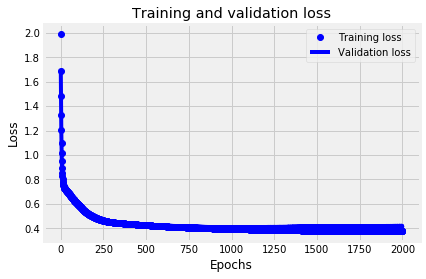

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']

epochs=range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo' , label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

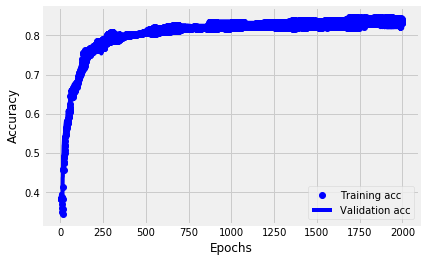

In [18]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo' , label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
dnn_predict = model_dnn.predict(data_x)

print(dnn_predict)

[[0.04147565]
 [0.32228094]
 [0.07412118]
 [0.09810862]
 [0.4495818 ]
 [0.10209438]
 [0.71494246]
 [0.17137262]
 [0.7477031 ]
 [0.02404469]
 [0.04771531]
 [0.28589904]
 [0.95928264]
 [0.06129485]
 [0.95790374]
 [0.8821076 ]
 [0.11703157]
 [0.08772311]
 [0.21644196]
 [0.67725396]
 [0.17381084]
 [0.9704449 ]
 [0.97237307]
 [0.3601847 ]
 [0.85397744]
 [0.03566769]
 [0.97215545]
 [0.08612928]
 [0.2997593 ]
 [0.04283145]
 [0.07210776]
 [0.13148922]
 [0.5993421 ]
 [0.6068061 ]
 [0.4712394 ]
 [0.09043902]
 [0.5026326 ]
 [0.5000341 ]
 [0.09628466]
 [0.1367554 ]
 [0.02602524]
 [0.32271183]
 [0.04307759]
 [0.9143938 ]
 [0.9589703 ]
 [0.09628466]
 [0.27581912]
 [0.04228145]
 [0.9322542 ]
 [0.597793  ]
 [0.49257928]
 [0.2865399 ]
 [0.5350893 ]
 [0.84859174]
 [0.1755099 ]
 [0.07708648]
 [0.04651326]
 [0.06491601]
 [0.0379881 ]
 [0.97539115]
 [0.06004784]
 [0.21423301]
 [0.06063715]
 [0.6976993 ]
 [0.70914245]
 [0.91944385]
 [0.68885934]
 [0.3670085 ]
 [0.44438905]
 [0.66529316]
 [0.7020649 ]
 [0.06

In [41]:
y_final = (dnn_predict > 0.5).astype(int).ravel()
print(y_final)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 0 1 1 0 0 1 0 0 1]


In [43]:


submission = pd.DataFrame({
        "PassengerId": data["PassengerId"],
        "Survived": y_final
    })
submission.to_csv('submission_dnn3.csv', index=False)